In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
import os



#Libraries import + basic setup

IMG_SIZE = 320 
IMG_SIZE2= 128
BATCH_SIZE = 16  

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

#the folder "./data/brain_tumor_data" or the one where the dataset is kept
#must contain the four folders:
# 0_no_tumor, 1_glioma, 2_meningioma, 3_pituitary
dataset_path = "./data/brain_tumor_data"

In [ ]:
#Upload datas

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Classi trovate: {full_dataset.class_to_idx}")


# Division between Train dataset and Validation dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloader to create a virtual training enviornment
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Classi trovate: {'0_no_tumor': 0, '1_glioma': 1, '2_meningioma': 2, '3_pituitary': 3}


In [ ]:
# Architecture of the neural network (BrainMRI_MLP)

class BrainMRI_MLP(nn.Module):

    def __init__(self):
        super(BrainMRI_MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        
     # Layer 1
        self.fc1 = nn.Linear(320 * 320, 128) 
        
        # Layer 2
        self.fc2 = nn.Linear(128, 64)
        
        # Output Layer: 
        self.fc3 = nn.Linear(64, 4) 
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
       
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
    
        x = self.fc3(x)
        
        return x
    
# Creation of the model and eventual translation on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainMRI_MLP().to(device)

print(model)

total_parameters = sum(p.numel() for p in model.parameters())
print(f"Totale parametri da allenare: {total_parameters:,}") 


BrainMRI_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=102400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)
Totale parametri da allenare: 13,115,844


In [ ]:


# Upload of the already saved model
model.load_state_dict(torch.load("brain_tumor_classifier_320px.pth"))
model.eval() # No dropout, no training



BrainMRI_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=102400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)

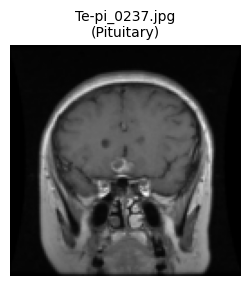

--- ANALISI DIRETTA SU VAL_DATASET ---
Indice in val_dataset: 596
Predizione: 3 (Pituitary)
Realtà: 3 (Pituitary)
0=No Tumor, 1=Glioma, 2=Meningioma, 3=Pituitary


In [ ]:
#RANDOM IMAGE CHOICE + DIAGNOSIS

# Let's generate a random number between 0 and the lenght of the dataset
idx = random.randint(0, len(val_dataset) - 1)
#Preleviamo un'immagine e la sua etichetta reale

image, label = val_dataset[idx]

# Random choice of the index
idx = random.randint(0, len(val_dataset) - 1)
image, label = val_dataset[idx]

# Recovery of the file name
origin_dataset = val_dataset.dataset
file_name = "unknown"

if hasattr(origin_dataset, 'samples'):
    original_index = val_dataset.indices[idx]
    full_path = origin_dataset.samples[original_index][0]
    file_name = os.path.basename(full_path)

# Resizing
resizer = transforms.Resize((IMG_SIZE2, IMG_SIZE2))
small_image = resizer(image)

class_names = {0: "No Tumor", 1: "Glioma", 2: "Meningioma", 3: "Pituitary"}
label_text = class_names.get(label, "Unknown")


# 5. Simplified visualization
plt.figure(figsize=(3, 3))
plt.imshow(small_image.squeeze().numpy(), cmap='gray')
plt.title(f"{file_name}\n({label_text})", fontsize=10)
plt.axis('off')
plt.show()

output = model(image.unsqueeze(0).to(device))
prediction = output.argmax().item()


print(f"--- ANALISI DIRETTA SU VAL_DATASET ---")
print(f"Indice in val_dataset: {idx}")
print(f"Predizione: {prediction} ({class_names.get(prediction)})")
print(f"Realtà: {label} ({class_names.get(label)})")



print("0=No Tumor, 1=Glioma, 2=Meningioma, 3=Pituitary") 



In [ ]:
# TRAINING LOOP (Backpropagation)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch_number = 10 

print("\nInizio Training...")
    
for epoch in range(epoch_number):
    running_loss = 0.0
    for images, labels in train_loader:
    
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images) #predictions
    
        loss=criterion(outputs, labels)
    
        optimizer.zero_grad() #gradient evaluation
        loss.backward()
        optimizer.step() #movement of the cost function
        
        running_loss += loss.item()/len(train_loader)
        
    avg_loss=running_loss/len(train_loader)
    print(f"Epoch: {epoch+1}, Loss batch {loss.item():.6f}, avg loss{avg_loss:.6f}")

print("Training completato.")

#save
torch.save(model.state_dict(), "brain_tumor_classifier_320px.pth")
print("Modello salvato come 'brain_tumor_classifier_320px.pth'")




Inizio Training...
Epoch: 1, Loss batch 0.000001, avg loss0.000012
Epoch: 2, Loss batch 0.000220, avg loss0.000002
Epoch: 3, Loss batch 0.000332, avg loss0.000001
Epoch: 4, Loss batch 0.000260, avg loss0.000001
Epoch: 5, Loss batch 0.000002, avg loss0.000001
Epoch: 6, Loss batch 0.001595, avg loss0.000001
Epoch: 7, Loss batch 0.000000, avg loss0.000001
Epoch: 8, Loss batch 0.001905, avg loss0.000001
Epoch: 9, Loss batch 0.000110, avg loss0.000001
Epoch: 10, Loss batch 0.001292, avg loss0.000001
Training completato.
Modello salvato come 'brain_tumor_classifier_320px.pth'


In [ ]:
# executing this cell, the model completely resets itself
model = BrainMRI_MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)